In [1]:
import model_utils as mu
mu.DEATH_RATE = 0.36
mu.ICU_RATE = 0.78
mu.HOSPITAL_RATE = 2.18
mu.SYMPTOM_RATE = 10.2
mu.INFECT_2_HOSPITAL_TIME = 11
mu.HOSPITAL_2_ICU_TIME = 4
mu.ICU_2_DEATH_TIME = 4
mu.ICU_2_RECOVER_TIME = 7
mu.NOT_ICU_DISCHARGE_TIME = 5

In [2]:
import pandas as pd


In [3]:
log_pre, mb = mu.get_log_daily_predicted_death_by_country('Singapore', lockdown_date='20200415')

TypeError: get_log_daily_predicted_death_by_country() got an unexpected keyword argument 'lockdown_date'

In [4]:
daily_metrics, cum_metrics, model_beta = mu.get_metrics_by_country('Iraq', lockdown_date='20200322', relax_date='20200411')

NumExpr defaulting to 4 threads.
C:\Users\Quoc\bitbucket\covid-19\prognosis\model_utils.py:263: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_new)


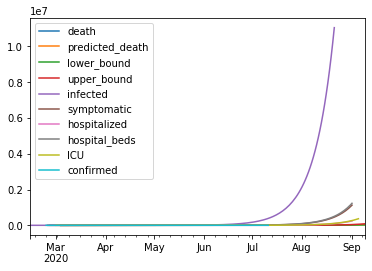

In [5]:
daily_metrics.plot()

In [6]:
import plotly.offline as py_offline
import cufflinks as cf
cf.go_offline()
py_offline.__PLOTLY_OFFLINE_INITIALIZED = True

In [7]:
daily_metrics.iplot()

In [5]:
import numpy as np

In [14]:
from sklearn import linear_model

In [40]:
local_death_data = mu.get_data_by_country('US', type='deaths')
daily_local_death_new = mu.get_daily_data(local_death_data)
daily_local_death_new.columns = ['death']
log_daily_death = np.log(daily_local_death_new)
data_start_date = min(local_death_data.index)
data_time_idx = (log_daily_death.index - data_start_date).days.values
log_daily_death['time_idx'] = data_time_idx
log_daily_death = log_daily_death.replace([np.inf, -np.inf], np.nan).dropna()

C:\Users\Quoc\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [41]:
local_death_data.head()

,0
2020-02-29,1.0
2020-03-01,1.0
2020-03-02,6.0
2020-03-03,7.0
2020-03-04,11.0


In [42]:
break_points = np.array([0, 12, 60, 93])
robust_reg = linear_model.HuberRegressor(fit_intercept=True)

In [43]:
log_daily_death.query('time_idx<12&time_idx>3')

,death,time_idx
2020-03-04,1.386294,4
2020-03-05,0.000000,5
2020-03-06,0.693147,6
2020-03-07,1.098612,7
2020-03-08,1.386294,8
2020-03-09,0.000000,9
2020-03-10,1.791759,10
2020-03-11,2.079442,11


In [58]:
def remove_outliers(log_daily_death, break_points):
    ''' Remove outliers by running robust linear regression in each section'''
    robust_reg = linear_model.HuberRegressor(fit_intercept=True)
    outliers = np.array([],dtype=bool)
    for i in range(len(break_points)-1):
        data_train = log_daily_death.query('time_idx>={}&time_idx<{}'.format(break_points[i], break_points[i+1]))
        try:
            robust_reg.fit(data_train.time_idx.values.reshape(-1, 1), data_train.death)
            outliers_pw = robust_reg.outliers_
        except:
            outliers_pw = np.array([False] * len(data_train))
        outliers = np.concatenate((outliers, outliers_pw))
    #Last section
    data_train = log_daily_death.query('time_idx>={}'.format(break_points[-1]))
    try:
        robust_reg.fit(data_train.time_idx.values.reshape(-1, 1), data_train.death)
        outliers_pw = robust_reg.outliers_
    except:
        outliers_pw = np.array([False] * len(data_train))
    outliers = np.concatenate((outliers, outliers_pw))
    return log_daily_death[~outliers]

In [60]:
remove_outliers(log_daily_death,break_points)

,death,time_idx
2020-03-03,0.000000,3
2020-03-04,1.386294,4
2020-03-06,0.693147,6
2020-03-07,1.098612,7
2020-03-08,1.386294,8
...,...,...
2020-06-04,6.943122,96
2020-06-06,6.563856,98
2020-06-09,6.890609,101
2020-06-10,6.835185,102


In [56]:
outliers = np.array([],dtype=bool)
for i in range(len(break_points)-1):
    print(break_points[i], break_points[i+1]-1)
    data_train = log_daily_death.query('time_idx>={}&time_idx<{}'.format(break_points[i], break_points[i+1]))
    print(data_train)
    try:
        robust_reg.fit(data_train.time_idx.values.reshape(-1, 1), data_train.death)
        outliers_pw = robust_reg.outliers_
    except:
        outliers_pw = np.array([False] * len(data_train))
    outliers = np.concatenate((outliers, outliers_pw))
data_train = log_daily_death.query('time_idx>={}'.format(break_points[-1]))
print(data_train)
try:
    robust_reg.fit(data_train.time_idx.values.reshape(-1, 1), data_train.death)
    outliers_pw = robust_reg.outliers_
except:
    outliers_pw = np.array([False] * len(data_train))
outliers = np.concatenate((outliers, outliers_pw))
len(outliers)
    

0 11
               death  time_idx
2020-03-02  1.609438         2
2020-03-03  0.000000         3
2020-03-04  1.386294         4
2020-03-05  0.000000         5
2020-03-06  0.693147         6
2020-03-07  1.098612         7
2020-03-08  1.386294         8
2020-03-09  0.000000         9
2020-03-10  1.791759        10
2020-03-11  2.079442        11
12 59
               death  time_idx
2020-03-12  1.791759        12
2020-03-13  2.079442        13
2020-03-14  2.302585        14
2020-03-15  2.639057        15
2020-03-16  3.258097        16
2020-03-17  3.526361        17
2020-03-18  3.433987        18
2020-03-19  4.543295        19
2020-03-20  4.510860        20
2020-03-21  4.521789        21
2020-03-22  4.976734        22
2020-03-23  5.293305        23
2020-03-24  5.416100        24
2020-03-25  5.733341        25
2020-03-26  6.006353        26
2020-03-27  6.297109        27
2020-03-28  6.163315        28
2020-03-29  6.516193        29
2020-03-30  6.654153        30
2020-03-31  7.065613        

102

In [57]:
log_daily_death[~outliers]

,death,time_idx
2020-03-03,0.000000,3
2020-03-04,1.386294,4
2020-03-06,0.693147,6
2020-03-07,1.098612,7
2020-03-08,1.386294,8
...,...,...
2020-06-04,6.943122,96
2020-06-06,6.563856,98
2020-06-09,6.890609,101
2020-06-10,6.835185,102


In [ ]:
mu.get_cumulative_predicted_death(local_death_data, forecast_horizon=60, lockdown_date='20200317')

In [2]:
import pandas as pd

In [5]:
data = pd.read_csv('logs/fitted_models.csv', header=None)

In [8]:
data.columns = ['dt', 'scope', 'local', 'params']

In [14]:
data.tail(60)

,dt,scope,local,params
306,2020-04-21 11:41:08.495599,Country,US,[-0.74691073 0.22789085 -0.19837405]
307,2020-04-21 11:45:24.318539,Country,US,[-0.74691073 0.22789085 -0.19837405]
308,2020-04-21 11:46:59.483013,Country,US,[-0.74691073 0.22789085 -0.19837405]
309,2020-04-21 11:48:18.484366,Country,US,[-0.74691073 0.22789085 -0.19837405]
310,2020-04-21 11:52:03.824622,Country,US,[-0.74691073 0.22789085 -0.19837405]
311,2020-04-21 11:55:41.277976,Country,US,[-0.74691073 0.22789085 -0.19837405]
312,2020-04-21 11:56:08.162725,Country,US,[-0.74691073 0.22789085 -0.19837405]
313,2020-04-21 11:56:40.469168,Country,US,[-0.74691073 0.22789085 -0.19837405]
314,2020-04-21 11:59:43.700774,Country,US,[-0.74691073 0.22789085 -0.19837405]
315,2020-04-21 12:03:53.492699,Country,US,[-0.74691073 0.22789085 -0.19837405]


In [18]:
len(data.params[0])

37

In [24]:
data.params[0][1:36].split(' ')

['-0.47877307', '', '0.22554814', '-0.24821284']

In [27]:
eval(data.params[0][25:36])

-0.24821284

In [37]:
data.params.apply(lambda x: x[25:36]).astype(float)

ValueError: could not convert string to float: '        ]'

In [ ]:
data.params.apply(lambda x: x[25:36]).astype

In [ ]:
data.params.apply(lambda x: x[25:36]).astype

In [32]:
data.head(20)

,dt,scope,local,params
0,2020-04-14 15:24:03.087423,Country,US,[-0.47877307 0.22554814 -0.24821284]
1,2020-04-14 15:24:19.681201,State,California,[-0.57772623 0.13889107 -0.26399057]
2,2020-04-14 15:25:02.143226,State,Washington,[ 0.59323822 0.06917945 -1.17005941]
3,2020-04-14 15:25:15.592145,State,Washington,[ 0.59323822 0.06917945 -1.17005941]
4,2020-04-14 15:25:41.659834,State,New York,[ 2.07115577 0.20522476 -0.69599522]
5,2020-04-14 16:09:48.265701,State,Florida,[-0.79350822 0.13816607 0. ]
6,2020-04-14 16:26:51.216209,State,New Jersey,[-0.86745437 0.22828028 -0.54454653]
7,2020-04-14 16:28:35.042487,State,Michigan,[1.4126235 0.15679606 0. ]
8,2020-04-14 16:29:55.123932,State,Michigan,[ 1.32781308 0.16434707 -0.88261295]
9,2020-04-14 16:30:17.876613,State,Michigan,[ 1.19293745 0.17711308 -0.53344374]
